# Bimbo Advanced Price Elasticity GBM Proposal

### Libraries and General Settings

In [115]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#### ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
### Others
import warnings
# ignore all warnings
warnings.filterwarnings("ignore")

In [116]:
# Constants and Parameters

### MONOTONIC CONSTRAINTS ARRAY
# Positions [so_unit_price, so_lag1, so_lag2,'promo_flag','holiday_flag','week_year'  ]
CONSTRAINTS = [-1, -1, -1, 1, 1, 0]

### INPUT DATA
FILE_NAME = '../inputs/fake_db_input.csv'

### OUTPUT
OUTPUT_FILE = '../outputs/reporte_elasticidad_lags.csv'

### Random State
SEED = 42

### Functions

In [117]:
def calculate_long_run_elasticity(model, X_sample, price_cols, percentage=0.01):
    """
    (EN) Simulates a permanent price increase (current and lags) to
    extract long time elasticity from the blackbox.
    
    (ES)Simula un incremento permanente del precio (actual y rezagos) 
    para extraer la elasticidad de largo plazo de la caja negra.
    """
    base_pred = model.predict(X_sample)
    base_pred = np.where(base_pred <= 0, 1e-9, base_pred)
    
    # Simulates a permanent increase (1%)
    X_sim = X_sample.copy()
    for col in price_cols:
        X_sim[col] = X_sim[col] * (1 + percentage)
    
    sim_pred = model.predict(X_sim)
    pct_change_q = (sim_pred - base_pred) / base_pred
    return np.mean(pct_change_q) / percentage


def write_final_report(df_report=pd.DataFrame(), file_name='', format='csv'):
    """
    (EN) Write final report with the modelling results.
    
    (ES) Escribe el reporte final con los resultados del modelamiento.
    """
    status = True

    try:
        # Classifying the results by case
        df_report['Case'] = np.where(df_report['Mape_Test'] > 0.2, 'MAPE fuera de rango admitido',
                            np.where(df_report['Elast_Sellout'] > 0, 'Elasticidad SO positiva',
                            np.where(df_report['Elast_Sellin'] > 0, 'Elasticidad SI Positiva',
                            'OK'  )))

        if format == 'csv':
            df_report.to_csv(file_name, index=False)
        elif format == 'excel':
            df_report.to_excel(file_name, index=False)  
        else:
            status = False
    except:
        status = False
    
    return status

### Modelling

In [118]:
# 1. Loading Data
df = pd.read_csv(FILE_NAME)
df['week_year'] = df['anio_sem'].astype(str).str[-2:].astype(int)

results = []
skus = df['sku'].unique()
sku_models = {} # Para guardar modelos y usarlos en las curvas

for sku in skus:
    df_sku = df[df['sku'] == sku].sort_values('anio_sem').reset_index(drop=True)
    
    # Data requirement incremented to support lags (t-2)
    ### 20 will allow us to train with at least ~14 weeks and test with ~4
    if len(df_sku) < 20:
        continue
    
    # --- FEATURE ENGINEERING: Lag creation (Lags) ---
    # Sell-in Lags for Pass-through
    df_sku['si_lag1'] = df_sku['si_unit_price'].shift(1)
    df_sku['si_lag2'] = df_sku['si_unit_price'].shift(2)
    
    # Sell-out Lags for Demand
    df_sku['so_lag1'] = df_sku['so_unit_price'].shift(1)
    df_sku['so_lag2'] = df_sku['so_unit_price'].shift(2)
    
    df_clean = df_sku.dropna().copy()
    
    # --- Stage 1: Pass-through (Distributed Lag Model) ---
    X_pt = df_clean[['si_unit_price', 'si_lag1', 'si_lag2']]
    y_pt = df_clean['so_unit_price']
    
    pt_model = LinearRegression().fit(X_pt, y_pt)
    # The total pass-through is the sum of the coefficients (Cummulative Effect)
    total_pass_through = pt_model.coef_.sum()
    
    # --- Stage 2: Demand Model with Lags (GBM) ---
    price_features = ['so_unit_price', 'so_lag1', 'so_lag2']
    other_features = ['promo_flag', 'holiday_flag', 'week_year']
    X_demand = df_clean[price_features + other_features]
    y_demand = df_clean['so_volume']
    
    # Temp partition 
    split = int(len(df_clean) * 0.8)
    X_train, X_test = X_demand.iloc[:split], X_demand.iloc[split:]
    y_train, y_test = y_demand.iloc[:split], y_demand.iloc[split:]
    
    model_gb = HistGradientBoostingRegressor( max_iter=50,
                                              learning_rate=0.05,
                                              max_depth=2,
                                              min_samples_leaf=2,
                                              monotonic_cst=CONSTRAINTS,
                                              random_state=SEED)
    model_gb.fit(X_train, y_train)
    
    # Performance Metrics 
    mape_train = mean_absolute_percentage_error(y_train + 1e-9, model_gb.predict(X_train))
    mape_test = mean_absolute_percentage_error(y_test + 1e-9, model_gb.predict(X_test))
    
    # --- Stage 3: Elasticity Extraction  ---
    # Sell-Out Elasticity (Long Run)
    elast_so = calculate_long_run_elasticity(model_gb, X_demand, price_features)
    
    # Sell-In Elasticity (Effective impact to the company)
    elast_si = total_pass_through * elast_so

    
    sku_models[sku] = {'pt': pt_model, 'gb': model_gb, 'data': df_clean}
    
    results.append({
        'SKU': sku,
        'Pass_through': round(total_pass_through, 4),
        'Elast_Sellin': round(elast_si, 4),
        'Elast_Sellout': round(elast_so, 4),
        'Mape_Test': round(mape_test, 4),
        'Mape_Train': round(mape_train, 4)
    })

# Generating Final Output 
df_report = pd.DataFrame(results)
df_report.to_csv(OUTPUT_FILE, index=False)
print(df_report.head())

        SKU  Pass_through  Elast_Sellin  Elast_Sellout  Mape_Test  Mape_Train
0  SKU-1000        0.9714       -2.2177        -2.2829     0.1377      0.0693
1  SKU-1001        1.5629       -1.9544        -1.2505     0.1288      0.0863
2  SKU-1002        0.4038       -0.2013        -0.4985     0.2234      0.0626
3  SKU-1003        1.3613       -1.3868        -1.0187     0.0703      0.0406
4  SKU-1004        1.5055       -1.9318        -1.2832     0.1172      0.0430


In [119]:
# Saving Report File
write_final_report(df_report, OUTPUT_FILE)

True

In [120]:
# Checking Results
df_report.sort_values(by=['Case'],
                     ascending=False)

,SKU,Pass_through,Elast_Sellin,Elast_Sellout,Mape_Test,Mape_Train,Case
0,SKU-1000,0.9714,-2.2177,-2.2829,0.1377,0.0693,OK
1,SKU-1001,1.5629,-1.9544,-1.2505,0.1288,0.0863,OK
23,SKU-1023,1.0323,-2.0510,-1.9868,0.1444,0.0649,OK
22,SKU-1022,1.4472,-2.9934,-2.0684,0.0779,0.0450,OK
21,SKU-1021,1.4747,-2.5923,-1.7578,0.0771,0.0756,OK
19,SKU-1019,1.2716,-0.9644,-0.7585,0.1332,0.0587,OK
18,SKU-1018,1.1669,-1.0485,-0.8985,0.0841,0.0481,OK
17,SKU-1017,1.8749,-4.7084,-2.5113,0.1074,0.0715,OK
16,SKU-1016,1.5303,-2.6226,-1.7138,0.0942,0.0643,OK
15,SKU-1015,1.7663,-7.1744,-4.0617,0.1671,0.0832,OK


### Simulations 1

Iniciando entrenamiento y simulaciones...

--- MATRIZ DE ESCENARIOS ---
        SKU  Pass_Through  Impacto_S1(+2%SI)  Impacto_S2(-10%SO_Promo)
0  SKU-1000      0.971430          -0.124615                  0.176393
1  SKU-1001      1.562891           0.000000                  0.262681
2  SKU-1002      0.403783           0.000000                  0.133712
3  SKU-1003      1.361315           0.000000                  0.000000
4  SKU-1004      1.505465          -0.011963                  0.115593


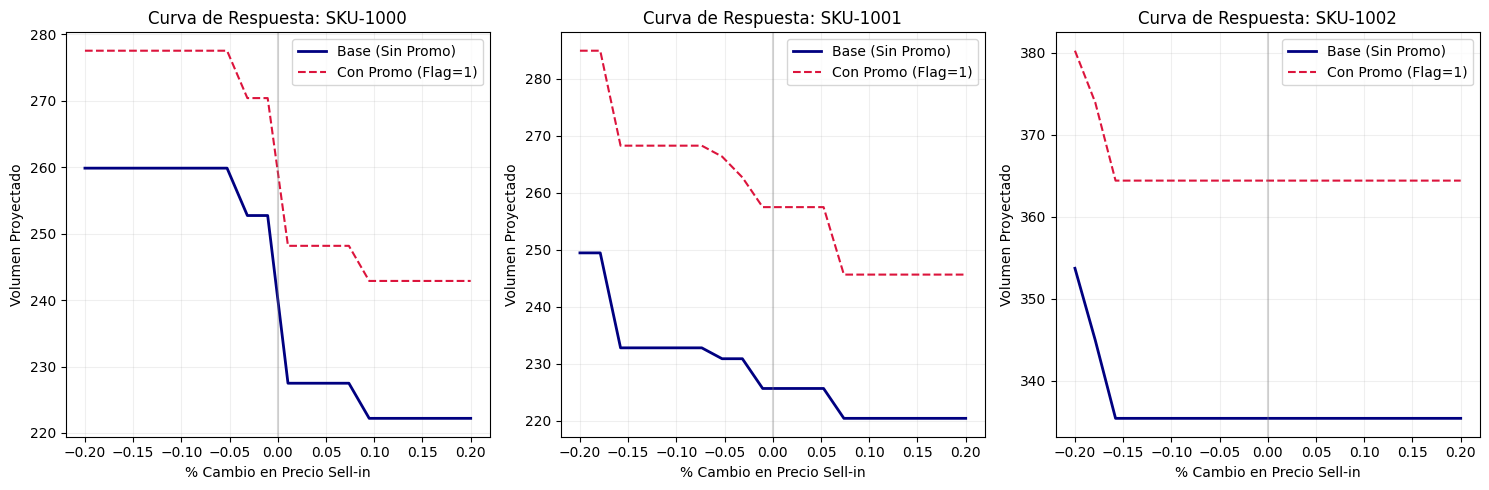

In [126]:
# 1. CARGA DE DATOS
df = pd.read_csv(FILE_NAME)
df['week_year'] = df['anio_sem'].astype(str).str[-2:].astype(int)

simulation_results = []
sku_models = {} # Para guardar modelos y usarlos en las curvas

print("Iniciando entrenamiento y simulaciones...")

for sku in df['sku'].unique():
    df_sku = df[df['sku'] == sku].sort_values('anio_sem').reset_index(drop=True)
    if len(df_sku) < 20: 
        continue
    
    # Feature Engineering (Lags)
    df_sku['si_lag1'] = df_sku['si_unit_price'].shift(1)
    df_sku['si_lag2'] = df_sku['si_unit_price'].shift(2)
    df_sku['so_lag1'] = df_sku['so_unit_price'].shift(1)
    df_sku['so_lag2'] = df_sku['so_unit_price'].shift(2)
    df_clean = df_sku.dropna().copy()
    
    # Stage 1: Pass-through
    X_pt = df_clean[['si_unit_price', 'si_lag1', 'si_lag2']]
    pt_model = LinearRegression().fit(X_pt, df_clean['so_unit_price'])
    total_pt = pt_model.coef_.sum()
    
    # Stage 2: Demand (HistGB)
    price_features = ['so_unit_price', 'so_lag1', 'so_lag2']
    other_features = ['promo_flag', 'holiday_flag', 'week_year']
    X = df_clean[price_features + other_features]
    y = df_clean['so_volume']
    
    model_gb = HistGradientBoostingRegressor(
        max_iter=50, max_depth=2, min_samples_leaf=2,
        monotonic_cst=CONSTRAINTS, random_state=SEED
    ).fit(X, y)
    
    # --- SIMULACIÓN DE ESCENARIOS ---
    last_week = df_clean.iloc[-1:].copy()
    base_vol = model_gb.predict(last_week[price_features + other_features])[0]
    
    # Escenario 1: +2% Sell-in
    s1_data = last_week.copy()
    s1_data[['si_unit_price', 'si_lag1']] *= 1.02
    new_so_p = pt_model.predict(s1_data[['si_unit_price', 'si_lag1', 'si_lag2']])[0]
    s1_data['so_unit_price'] = new_so_p
    vol_s1 = model_gb.predict(s1_data[price_features + other_features])[0]
    
    # Escenario 2: -10% Promo Sell-out
    s2_data = last_week.copy()
    s2_data['so_unit_price'] *= 0.90
    s2_data['promo_flag'] = 1
    vol_s2 = model_gb.predict(s2_data[price_features + other_features])[0]
    
    # Guardar resultados
    sku_models[sku] = {'pt': pt_model, 'gb': model_gb, 'data': df_clean}
    simulation_results.append({
        'SKU': sku,
        'Pass_Through': total_pt,
        'Impacto_S1(+2%SI)': (vol_s1 - base_vol) / base_vol,
        'Impacto_S2(-10%SO_Promo)': (vol_s2 - base_vol) / base_vol
    })

# 2. TABLA COMPARATIVA
df_sim = pd.DataFrame(simulation_results)
print("\n--- MATRIZ DE ESCENARIOS ---")
print(df_sim.head())

# 3. VISUALIZACIÓN DE CURVAS DE RESPUESTA (Top 3 SKUs)
top_skus = df_sim['SKU'].unique()[:3]
plt.figure(figsize=(15, 5))

for i, sku in enumerate(top_skus):
    plt.subplot(1, 3, i+1)
    res = sku_models[sku]
    
    # Generar rango de precios (-20% a +20%)
    price_deltas = np.linspace(-0.2, 0.2, 20)
    vols_reg = []
    vols_promo = []
    
    current_data = res['data'].iloc[-1:].copy()
    
    for d in price_deltas:
        sim_row = current_data.copy()
        sim_row[['si_unit_price', 'si_lag1']] *= (1 + d)
        new_p = res['pt'].predict(sim_row[['si_unit_price', 'si_lag1', 'si_lag2']])[0]
        sim_row['so_unit_price'] = new_p
        
        # Predicción Regular
        sim_row['promo_flag'] = 0
        vols_reg.append(res['gb'].predict(sim_row[price_features + other_features])[0])
        # Predicción Promo
        sim_row['promo_flag'] = 1
        vols_promo.append(res['gb'].predict(sim_row[price_features + other_features])[0])
        
    plt.plot(price_deltas, vols_reg, label='Base (Sin Promo)', color='navy', lw=2)
    plt.plot(price_deltas, vols_promo, label='Con Promo (Flag=1)', color='crimson', linestyle='--')
    plt.axvline(0, color='gray', alpha=0.3)
    plt.title(f"Curva de Respuesta: {sku}")
    plt.xlabel("% Cambio en Precio Sell-in")
    plt.ylabel("Volumen Proyectado")
    plt.legend()
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()